In [80]:
import normflows as nf 
import torch.optim as optim
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

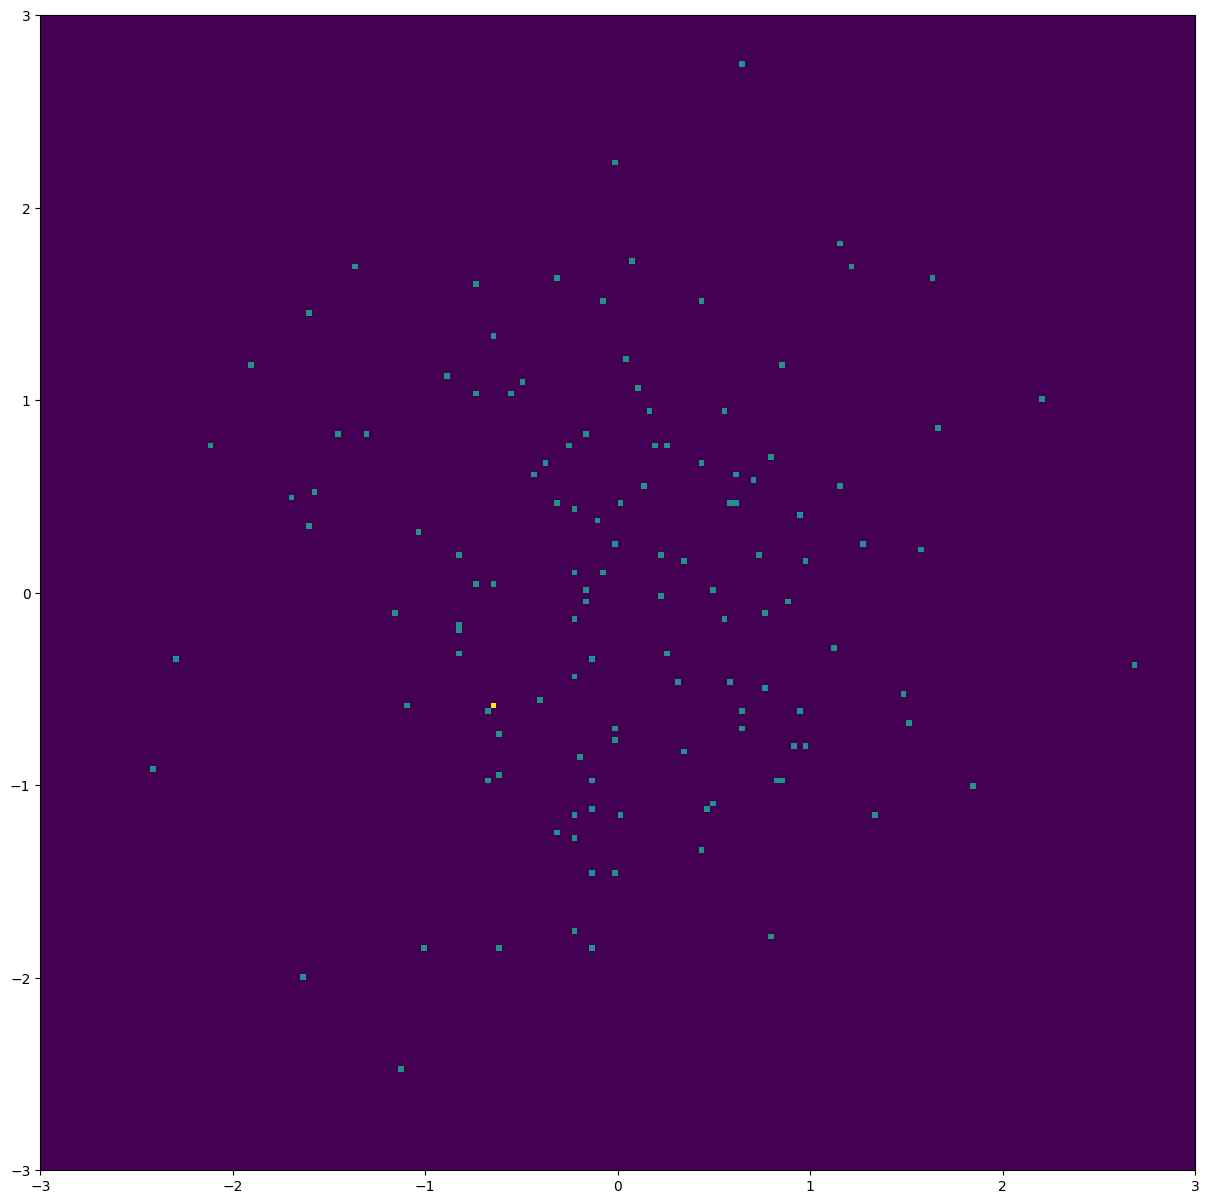

In [81]:
K = 64
torch.manual_seed(0)

latent_size = 2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]

target = nf.distributions.TwoModes(2, 0.1)
q0 = nf.distributions.DiagGaussian(2)

# If the target density is not given
model = nf.NormalizingFlow(q0, flows)

# If the target density is given
target = nf.distributions.target.TwoMoons()
nfm = nf.NormalizingFlow(q0, flows, target)


# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

# Initialize ActNorm
z, _ = nfm.sample(num_samples=2 ** 7)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(15, 15))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
plt.gca().set_aspect('equal', 'box')
plt.show()


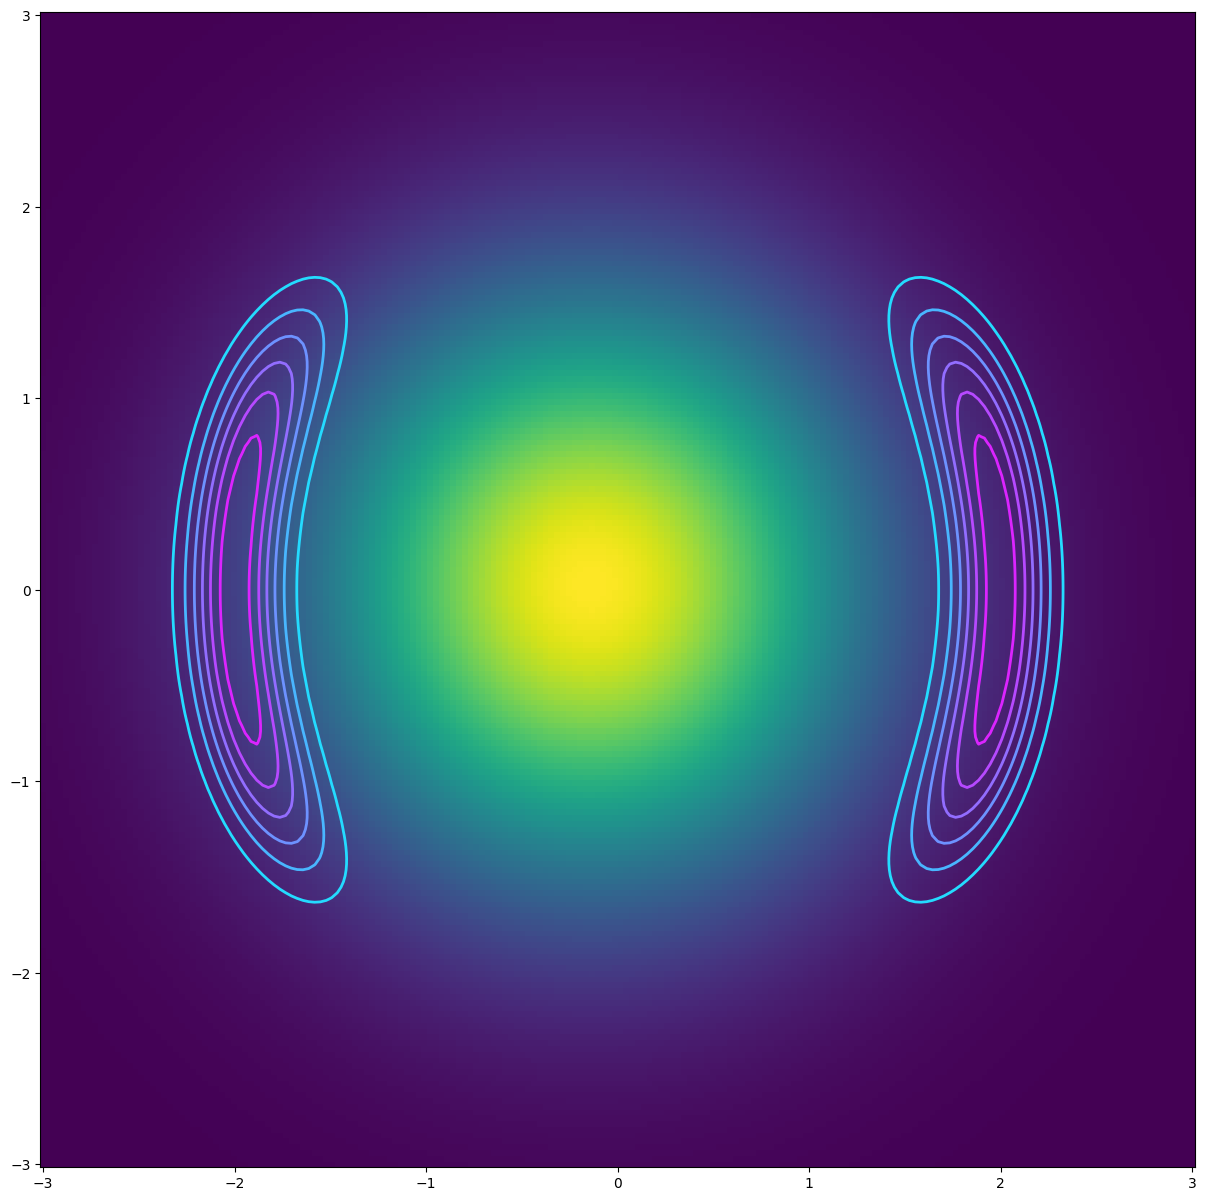

In [82]:

# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double().to(device)
log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob_target = torch.exp(log_prob)

# Plot initial posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_target.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()


In [83]:
# Train model
max_iter = 20000
num_samples = 50
anneal_iter = 10000
annealing = True
show_iter = 1000



loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-4, weight_decay=1e-6)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.001 + it / anneal_iter]))
    else:
        loss = nfm.reverse_alpha_div(num_samples, dreg=True, alpha=1)
    
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

100%|██████████| 20000/20000 [22:21<00:00, 14.91it/s]


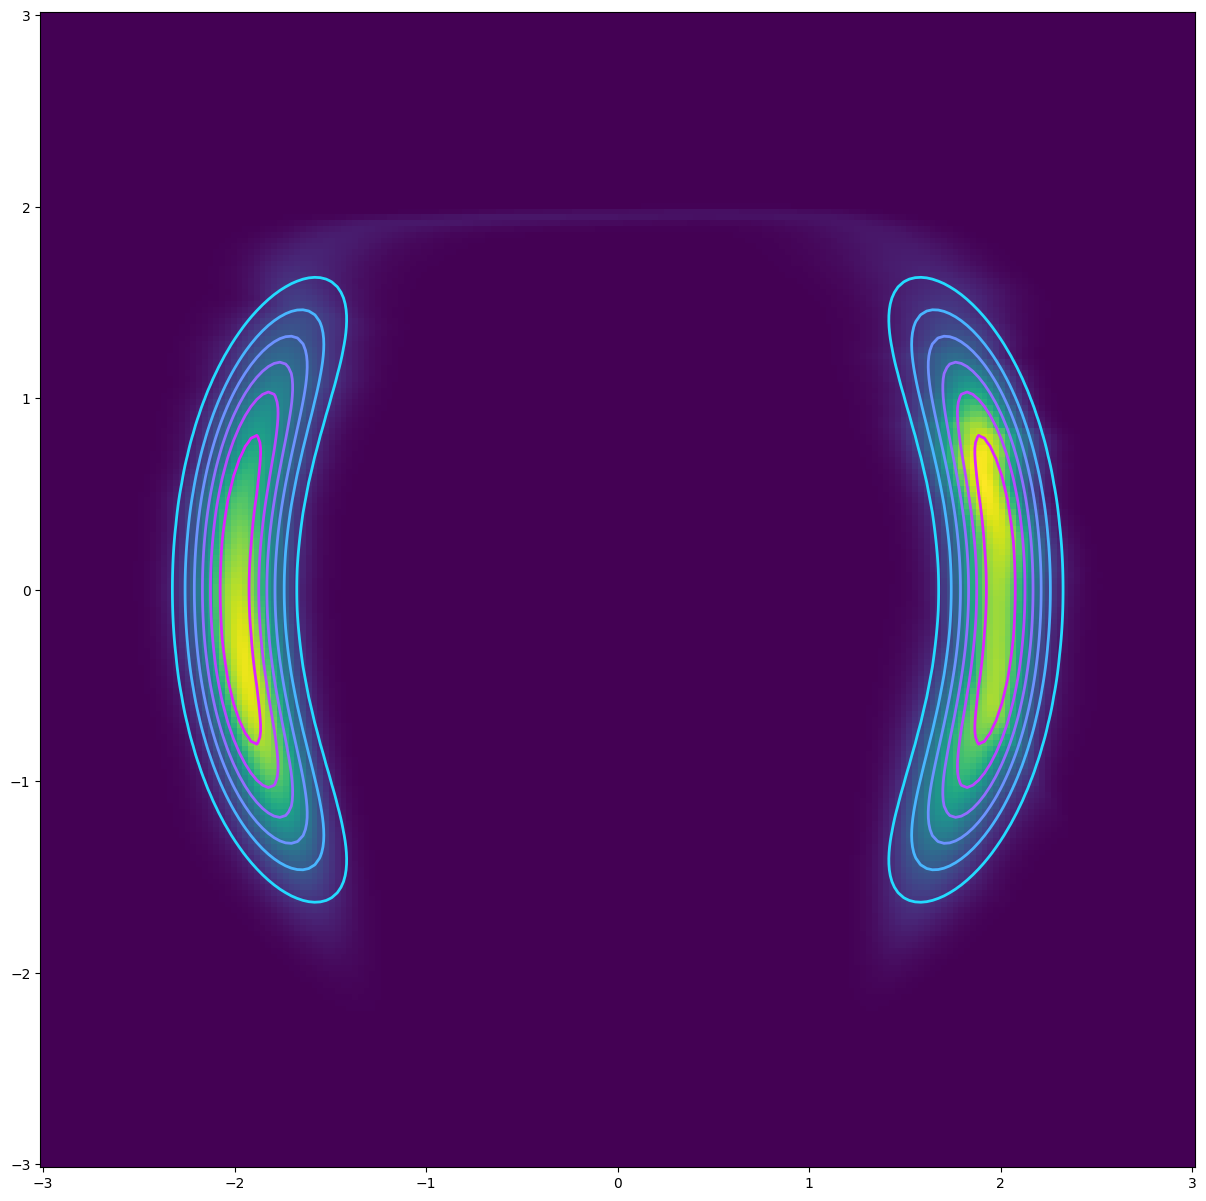

In [84]:




# Plot learned posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_target.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()



     


